In [304]:
from __future__ import print_function, division

In [305]:
import requests
import time
from bs4 import BeautifulSoup
import random
# import urllib2
# from urllib2 import URLError
import time
import re
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import scipy.stats

from IPython.display import Image
%matplotlib inline

In [307]:
from __future__ import print_function, division
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from collections import defaultdict

from IPython.display import Image
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [308]:
import seaborn as sns
#import ml_insights as mli

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

In [309]:
# Top grossing 100 movies from 2016.
url = "http://www.boxofficemojo.com/yearly/chart/?yr=2016&view=releasedate&view2=domestic&sort=gross&order=DESC&&p=.htm"
response = requests.get(url)
response.status_code
page = response.text
soup = BeautifulSoup(page, "lxml")
tables = soup.find_all("table")
rows=[row for row in tables[3].find_all('tr')]

In [310]:
#get the table in the webpage including name of movie, total_gross, open and close information, etc
movies={}
for row in rows[6:106]:
    items=row.find_all('td')
    title=items[1].find('a')['href'][14:-4]
    movies[title] = [i.text for i in items[1:]]
list(movies.items());
box_office = list(movies.items())
df = pd.DataFrame.from_items(box_office).T
df = df.reset_index()
df = df[[0,1,2,3,4,5,6,7]]
df = df.rename(columns={0:"Movie",1:"Studio",2:"Total_Gross",3:"Theaters",4:"Opening",5:"Theaters2",6:"Open",7:"Close"})

In [311]:
#generate the links of each movies based on their names to get more information
linklist = []
for row in rows[6:106]:
    items = row.find_all("td")
    link = items[1].find("a")['href']
    linklist.append(("http://www.boxofficemojo.com/"+link))  
linklist;

In [312]:
# In each link, extract the information including Runtime, MPAA, Rating, Production Budget,Director which are not in the 
#orignal tables.
def getrunrating(linklist):
    runtime_list =[]
    rating_list =[]
    budget_list = []
    director_list = []
    for link2 in linklist:
        response2 = requests.get(link2)
        page2 = response2.text
        soup2 = BeautifulSoup(page2, "lxml")
        tables2 = soup2.find_all("table")
        rows=[row for row in tables[3].find_all('tr')]

        dtg_string2 = soup2.find(text=re.compile('Runtime'))
        runtime_list.append(dtg_string2.findNext().text)

        dtg_string3 = soup2.find(text=re.compile('MPAA Rating'))
        rating_list.append(dtg_string3.findNext().text)
        
        dtg_string4 = soup2.find(text=re.compile('Production Budget'))
        budget_list.append(dtg_string4.findNext().text)
        
        try:
            dtg_string5 = soup2.find(text=re.compile('Director'))
            director_list.append(dtg_string5.findNext().text)
        except:
            director_list.append("N/A")
    return runtime_list,rating_list,budget_list,director_list

In [313]:
#Call the function above
runtime_list,rating_list,budget_list,director_list = getrunrating(linklist)

In [314]:
#Incorporate the information above into the orginal table
df["Runtime"] = runtime_list
df["Rating"] = rating_list
df["Budget"] = budget_list
df["Director"] = director_list

In [315]:
#data clean
run_time =lambda x:pd.datetime.strptime(x, "%H hrs. %M min.").hour*60+pd.datetime.strptime(x, "%H hrs. %M min.").minute*1
df["Runtime"] = df["Runtime"].apply(run_time)
df["Budget"] = df["Budget"].apply(lambda x:1000000 if x == "N/A" else float(x[1:-8])*1000000)
df["Total_Gross"] = df["Total_Gross"].apply(lambda x:int(x.replace(",","")[1:]))
df = df.drop(['Opening', "Theaters","Theaters2"],axis=1)
df["Open"] = df["Open"].apply(lambda x:x+"/2016")
df["Open"] = df["Open"].apply(lambda x:dt.datetime.strptime(x,"%m/%d/%Y").date())

In [316]:
df["Rating"].unique()

array(['PG-13', 'PG', 'R'], dtype=object)

In [317]:
df["Rating"] = df["Rating"].apply(lambda x:1 if x=="PG-13" else 2 if x == "PG" else 3)
#else int(2) if x == "PG" else int(3) if x == "R"
df

,Movie,Studio,Total_Gross,Open,Close,Runtime,Rating,Budget,Director
0,Rogue One: A Star Wars Story,BV,532177324,2016-12-16,5/4,133,1,200000000.0,Gareth Edwards
1,Finding Dory,BV,486295561,2016-06-17,12/8,103,2,1000000.0,Angus MacLane (co-director)Andrew Stanton
2,Captain America: Civil War,BV,408084349,2016-05-06,9/22,147,1,250000000.0,Anthony RussoJoe Russo
3,The Secret Life of Pets,Uni.,368384330,2016-07-08,12/29,90,2,75000000.0,Chris Renaud
4,The Jungle Book (2016),BV,364001123,2016-04-15,9/29,105,2,175000000.0,Jon Favreau
5,Deadpool,Fox,363070709,2016-02-12,6/16,106,3,58000000.0,Tim Miller
6,Zootopia,BV,341268248,2016-03-04,8/4,108,2,1000000.0,Byron HowardRich Moore
7,Batman v Superman: Dawn of Justice,WB,330360194,2016-03-25,6/16,151,1,250000000.0,Zack Snyder
8,Suicide Squad,WB,325100054,2016-08-05,11/10,130,1,175000000.0,David Ayer
9,Sing,Uni.,270329045,2016-12-21,5/4,110,2,75000000.0,Garth Jennings


Challenge 1
Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

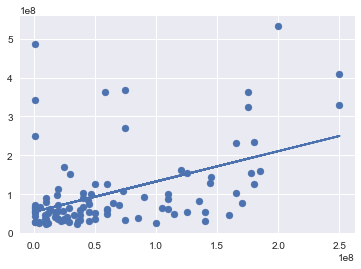

In [318]:
smaller_df = df
### smaller_df = df
list1 = np.array(list(smaller_df["Budget"].values))
list2 =  np.array(list(smaller_df["Total_Gross"].values))
Budget = np.reshape(list1,(len(list1),1))
Total_Gross = np.reshape(list2,(len(list1),1))
lr_model1 = LinearRegression()
lr_model1.fit(Budget,Total_Gross)
plt.scatter(Budget,Total_Gross)
plt.plot(Budget,lr_model1.intercept_ + lr_model1.coef_[0]*Budget)

R score is used to interpret the model. The r score for test data is 0.2. Relatively low correlation is observed between bedget and total_gross in this model

In [319]:
test_set_pred1 = lr_model1.predict(Budget)
np.sqrt(np.mean((test_set_pred1 - Total_Gross)**2))
lr_model1.score(Budget,Total_Gross)

0.21522445345419949

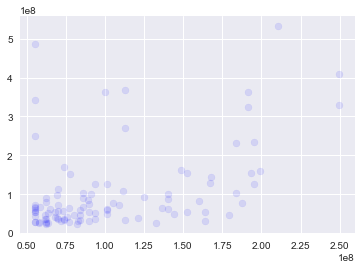

In [320]:
lr_model1.coef_
#plot of predictions against actual outcome
plt.scatter(test_set_pred1,Total_Gross,alpha=.1,color = "b")

(array([  1.,   1.,   2.,   1.,   4.,   2.,   5.,  30.,  42.,  12.]),
 array([ -4.30938181e+08,  -3.74568602e+08,  -3.18199024e+08,
         -2.61829445e+08,  -2.05459866e+08,  -1.49090287e+08,
         -9.27207087e+07,  -3.63511299e+07,   2.00184488e+07,
          7.63880275e+07,   1.32757606e+08]),
 <a list of 10 Patch objects>)

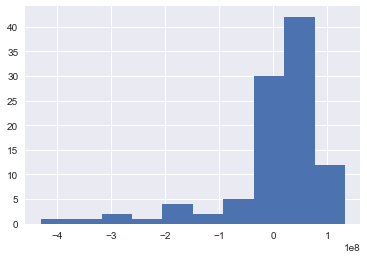

In [321]:
#a histogram of residuals
plt.hist(test_set_pred1 - Total_Gross)

Most residual scatter around x = 0

Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [322]:
X = smaller_df.loc[:,["Budget","Runtime"]]
y = smaller_df["Total_Gross"]
lr_model2 = LinearRegression()
lr_model2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [323]:
test_set_pred2 = lr_model2.predict(X)
np.sqrt(np.mean((test_set_pred2 - y)**2))
lr_model2.score(X,y)

0.21530942057748581

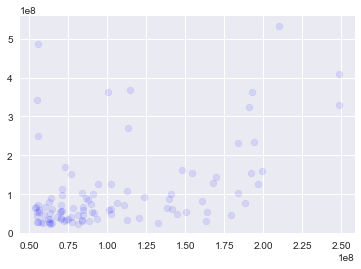

In [40]:
plt.scatter(test_set_pred2,y,alpha=.1,color = "b")

(array([  1.,   1.,   2.,   1.,   4.,   2.,   5.,  30.,  42.,  12.]),
 array([ -4.30822094e+08,  -3.74515138e+08,  -3.18208181e+08,
         -2.61901225e+08,  -2.05594268e+08,  -1.49287312e+08,
         -9.29803557e+07,  -3.66733993e+07,   1.96335571e+07,
          7.59405135e+07,   1.32247470e+08]),
 <a list of 10 Patch objects>)

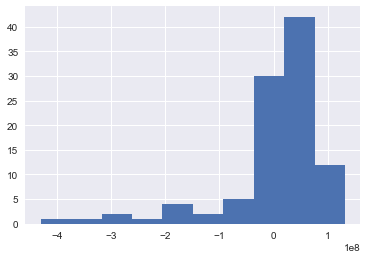

In [324]:
plt.hist(test_set_pred2 - y)

Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

In [325]:
X2 = smaller_df.loc[:,["Budget","Runtime","Rating"]]
y2 = smaller_df["Total_Gross"]
lr_model3 = LinearRegression()
lr_model3.fit(X2,y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [326]:
test_set_pred3 = lr_model3.predict(X2)
np.sqrt(np.mean((test_set_pred3 - y2)**2))
lr_model3.score(X2,y2)

0.21776887838948333

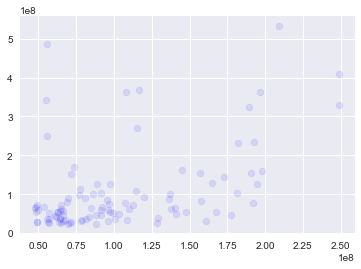

In [327]:
plt.scatter(test_set_pred3,y2,alpha=.1,color = "b")

(array([  1.,   1.,   1.,   2.,   4.,   2.,   5.,  25.,  46.,  13.]),
 array([ -4.30917922e+08,  -3.74827846e+08,  -3.18737770e+08,
         -2.62647695e+08,  -2.06557619e+08,  -1.50467544e+08,
         -9.43774682e+07,  -3.82873927e+07,   1.78026829e+07,
          7.38927584e+07,   1.29982834e+08]),
 <a list of 10 Patch objects>)

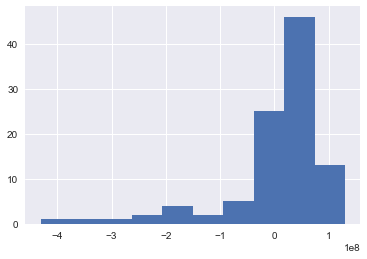

In [45]:
plt.hist(test_set_pred3 - y2)

Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

In [328]:
smaller_df['Open'] = pd.to_datetime(smaller_df['Open'])
smaller_df['Open']=smaller_df['Open'].map(dt.datetime.toordinal)
X3 = smaller_df.loc[:,["Budget","Runtime","Rating","Open"]]
y3 = smaller_df["Total_Gross"]
lr_model4 = LinearRegression()
lr_model4.fit(X3,y3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [330]:
test_set_pred4 = lr_model4.predict(X3)
np.sqrt(np.mean((test_set_pred4 - y3)**2))
lr_model4.score(X3,y3)

0.21801559945577054

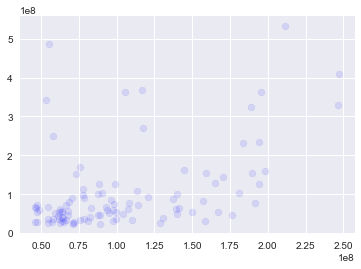

In [331]:
plt.scatter(test_set_pred4,y3,alpha=.1,color = "b")

(array([  1.,   1.,   1.,   2.,   4.,   1.,   6.,  25.,  46.,  13.]),
 array([ -4.31211106e+08,  -3.75162783e+08,  -3.19114459e+08,
         -2.63066135e+08,  -2.07017811e+08,  -1.50969487e+08,
         -9.49211637e+07,  -3.88728400e+07,   1.71754838e+07,
          7.32238075e+07,   1.29272131e+08]),
 <a list of 10 Patch objects>)

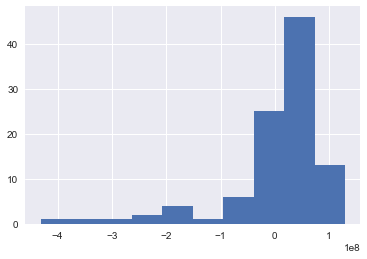

In [332]:
plt.hist(test_set_pred4 - y3)

Challenge 5

Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [333]:
X4 = smaller_df.loc[:,["Budget","Runtime","Rating","Open"]]
y4 = smaller_df["Total_Gross"]
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.25)
lr_model5 = LinearRegression()
lr_model5.fit(X_train,y_train)
list(zip(X_train.columns,lr_model5.coef_))

[('Budget', 0.84103861923153556),
 ('Runtime', -4844.924208011199),
 ('Rating', 7476907.7444698196),
 ('Open', -42749.455085027701)]

In [334]:
print(lr_model5.score(X_train,y_train))
print(lr_model5.score(X_test,y_test))

0.202732462159
0.0402085454595


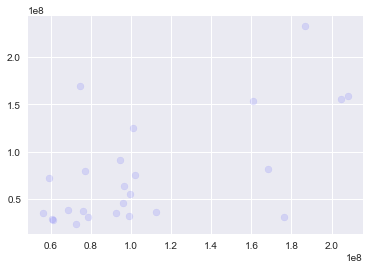

In [335]:
test_set_pred5 = lr_model5.predict(X_test)
plt.scatter(test_set_pred5,y_test,alpha=.1,color = "b")

Challenges 6

Challenge 1

Generate (fake) data that is linearly related to log(x).

You are making this model up. It is of the form B0 + B1*log(x) + epsilon. (You are making up the parameters.)

Simulate some data from this model.

Then fit two models to it:

quadratic (second degree polynomial)
logarithmic (log(x))
(The second one should fit really well, since it has the same form as the underlying model!)

In [336]:
x = np.linspace(1,2000,num = 2000)

In [337]:
y = 100+10*np.log(x)+sys.float_info.epsilon


In [338]:
x = np.reshape(x,(len(x),1))
y = np.reshape(y,(len(y),1))

lr_model6 = LinearRegression()
lr_model6.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

0.757856534787
0.757856534787


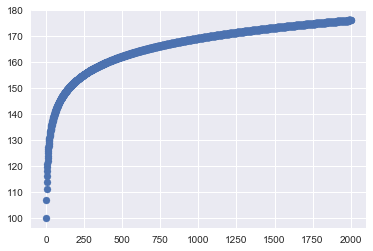

In [104]:
plt.scatter(x,y)
print(lr_model6.score(x,y))
print(lr_model6.score(x,y))

1.0
1.0


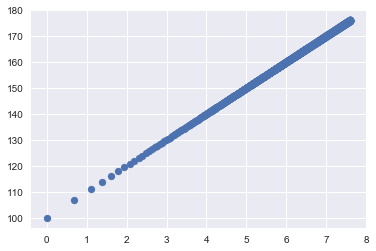

In [339]:
#logarithmic (log(x))
plt.scatter(np.log(x),y)
lr_model7=LinearRegression()
lr_model7.fit(np.log(x),y)
print(lr_model7.score(np.log(x),y))
print(lr_model7.score(np.log(x),y))

0.89652959104
0.89652959104


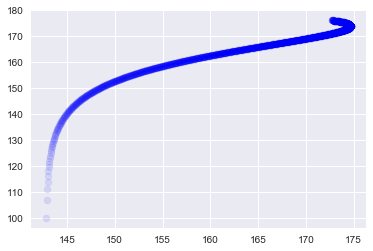

In [340]:
#quadratic (second degree polynomial) 
poly1 = PolynomialFeatures(2)
x_poly = poly1.fit_transform(x)

lr_model8 = LinearRegression()
lr_model8.fit(x_poly,y)
test_set_pred8 = lr_model8.predict(x_poly)
plt.scatter(test_set_pred8,y,alpha=.1,color = "b")
print(lr_model8.score(x_poly,y))
print(lr_model8.score(x_poly,y))

Challenge 2

Generate (fake) data from a model of the form B0 + B1*x + B2*x^2 + epsilon. (You are making up the parameters.)

Split the data into a training and test set.

Fit a model to your training set. Calculate mean squared error on your training set. Then calculate it on your test set.

(You could use sklearn.metrics.mean_squared_error.)

In [353]:
x2 = np.linspace(1,2000,num = 2000)
y2 = 100+10*x2+15*(x2)**2+sys.float_info.epsilon

In [354]:
x2 = np.reshape(x2,(len(x2),1))
y2 = np.reshape(y2,(len(y2),1))

In [355]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x2, y2, test_size=0.25)

In [360]:
# linear regression model with degree = 1
lr_model9 = LinearRegression()
lr_model9.fit(X_train_2,y_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [362]:
test_set_pred9 = lr_model9.predict(X_train_2)
test_set_pred10 = lr_model9.predict(X_test_2)

In [363]:
print(mean_squared_error(test_set_pred9,y_train_2))
print(mean_squared_error(test_set_pred10,y_test_2))

1.97549004376e+13
2.0782442695e+13


In [364]:
# linear regression model with degree = 2
poly2 = PolynomialFeatures(2)
X_train_2_p = poly2.fit_transform(X_train_2)
X_test_2_p = poly2.fit_transform(X_test_2)

In [365]:
lr_model10 = LinearRegression()
lr_model10.fit(X_train_2_p,y_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [366]:
test_set_pred110 = lr_model10.predict(X_train_2_p)
test_set_pred111 = lr_model10.predict(X_test_2_p)

In [367]:
print(lr_model10.score(X_train_2_p,y_train_2))
print(lr_model10.score(X_test_2_p,y_test_2))

1.0
1.0


In [368]:
print(mean_squared_error(test_set_pred110,y_train_2))
print(mean_squared_error(test_set_pred111,y_test_2))

2.70975602736e-17
2.939863562e-17


Challenge 3

For the data from two (above), try polynomial fits from 0th (just constant) to 7th order (highest term x^7). Over the x axis of model degree (8 points), plot:

training error
test error
R squared
AIC

In [369]:
degree_list = [1,2,3,4,5,6,7]
def poly(degree):
    X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(x2, y2, test_size=0.25)
    poly2 = PolynomialFeatures(degree)
    X_train_3_p = poly2.fit_transform(X_train_3)
    X_test_3_p = poly2.fit_transform(X_test_3)
    lr_model11 = LinearRegression()
    lr_model11.fit(X_train_3_p,y_train_3)
    #prediction
    train_set_pred112 = lr_model11.predict(X_train_3_p)
    test_set_pred113 = lr_model11.predict(X_test_3_p)
    #AIC
    model1 = sm.OLS(y_train_3, X_train_3_p)
    model2 = sm.OLS(y_test_3,X_test_3_p)
    fit1 = model1.fit()
    fit2 = model2.fit()
    aic_train = fit1.aic
    aic_test = fit2.aic
    #R score
    trainR = lr_model11.score(X_train_3_p,y_train_3)
    testR = lr_model11.score(X_test_3_p,y_test_3)
    #mean_square_error
    trainerror = mean_squared_error(train_set_pred112,y_train_3)
    testerror = mean_squared_error(test_set_pred113,y_test_3)
    
    return aic_train,aic_test,trainR,testR,trainerror,testerror

training_error_list = []
test_error_list = []
trainR_list = []
testR_list = []
aic_train_list = []
aic_test_list = []

for i in degree_list:
    aic_train,aic_test,trainR,testR,trainerror,testerror = poly(i)

    training_error_list.append(trainerror)
    test_error_list.append(testerror)
    trainR_list.append(trainR)
    testR_list.append(testR)
    aic_train_list.append(aic_train)
    aic_test_list.append(aic_test)


[20914994115208.137,
 1.7212108713178154e-17,
 1.6916797417754793e-12,
 1.2698156649628119e-05,
 678.45790887045348,
 13686.807188134711,
 4810063670.374135]

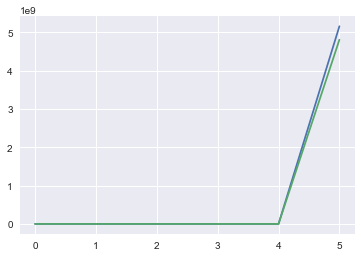

In [370]:
#error
plt.plot(training_error_list[1:])
plt.plot(test_error_list[1:])
test_error_list

In [371]:
test_error_list

[20914994115208.137,
 1.7212108713178154e-17,
 1.6916797417754793e-12,
 1.2698156649628119e-05,
 678.45790887045348,
 13686.807188134711,
 4810063670.374135]

[0.93584258030499279,
 1.0,
 1.0,
 1.0,
 0.99999999999789002,
 0.99999999995653566,
 0.99998449232198938]

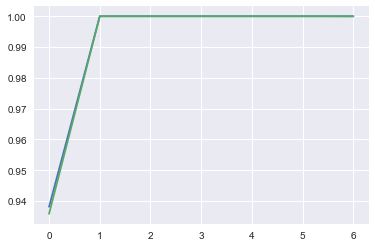

In [372]:
#R score
plt.plot(trainR_list)
plt.plot(testR_list)
testR_list

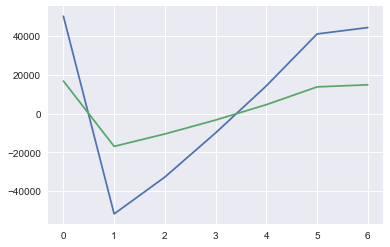

In [373]:
#AIC
plt.plot(aic_train_list)
plt.plot(aic_test_list)

Challenge 4

For the data from two (above), fit a model to only the first 5 of your data points (m=5). Then to first 10 (m=10). Then to first 15 (m=15). In this manner, keep fitting until you fit your entire training set. For each step, calculate the training error and the test error. Plot both (in the same plot) over m. This is called a learning curve.

In [374]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(x2, y2, test_size=0.25)

In [375]:
def linRegr(X_train,y_train):
    lr_model12 = LinearRegression()
    lr_model12.fit(X_train,y_train)
    train_set_pred14 = lr_model12.predict(X_train)
    test_set_pred15 = lr_model12.predict(X_test_4)
    
    #error
    trainerror2 = mean_squared_error(train_set_pred14,y_train)
    testerror2 = mean_squared_error(test_set_pred15,y_test_4)
    return trainerror2,testerror2
    

In [376]:
trainerror2_list = []
testerror2_list = []
for i in np.arange(5,1505,5):
    part_X_train = X_train_4[:i]
    part_y_train = y_train_4[:i]
    
    trainerror2,testerror2 = linRegr(part_X_train,part_y_train)
    trainerror2_list.append(trainerror2)
    testerror2_list.append(testerror2)
    
trainerror2_list; 
testerror2_list;

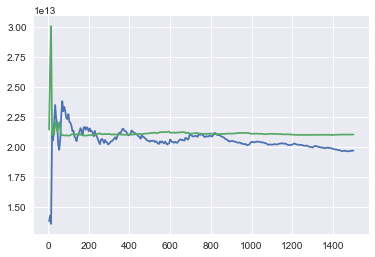

In [380]:
plt.plot(np.arange(5,1505,5),trainerror2_list)
plt.plot(np.arange(5,1505,5),testerror2_list)